In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
ds = tfds.load('deep_weeds', split='train', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/deep_weeds/3.0.0.incomplete1VLRVY/deep_weeds-train.tfrecord*...:   0%|    …

Dataset deep_weeds downloaded and prepared to /root/tensorflow_datasets/deep_weeds/3.0.0. Subsequent calls will reuse this data.


In [19]:
ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [3]:
import numpy as np
images_main = []
images_anomaly = []
labels_main= []
labels_anomaly = []
ds = ds.prefetch(tf.data.AUTOTUNE)
for example in ds:
  #print(np.array(example['label']))
  if np.array(example['label']) == 5:
    images_main.append(example["image"])
    labels_main.append(example["label"])
  if np.array(example['label']) == 1:
    images_anomaly.append(example["image"])
    labels_anomaly.append(example["label"])

In [4]:
np.array(images_main).shape

(1009, 256, 256, 3)

In [5]:
parc = round(len(labels_anomaly) * 0.01)
images_anomaly = np.array(images_anomaly)[:parc]
total_images = np.vstack([images_main, images_anomaly])

In [6]:
total_images.shape

(1020, 256, 256, 3)

In [7]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
#import argparse
import random
#import pickle
import cv2

In [8]:
(train_x, test_x) = train_test_split(total_images, test_size=0.2, random_state=0)

In [9]:
class Convolution_Autoencoder:
  @staticmethod
  def build(width, height, depth, filters=(16, 32, 64), latentDim=32):
    input_shape = (height, width, depth)
    chanDim = -1

    inputs = Input(shape=input_shape)
    x = inputs

    for f in filters:
      x = Conv2D(f, (3, 3), strides = 2, padding="same")(x)
      x = LeakyReLU(alpha=0.3)(x)
      x = BatchNormalization(axis=chanDim)(x)

    volume = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latentDim)(x)

    encoder = Model(inputs, latent, name="encoder")

    latent_layer_input = Input(shape=(latentDim,))
    x = Dense(np.prod(volume[1:]))(latent_layer_input)

    x = Reshape((volume[1], volume[2], volume[3]))(x)

    for f in filters[::-1]:
      x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
      x = LeakyReLU(alpha=0.3)(x)
      x = BatchNormalization(axis=chanDim)(x)

    x = Conv2DTranspose(depth, (3, 3), padding="same")(x)

    outputs = Activation("sigmoid")(x)

    decoder = Model(latent_layer_input, outputs, name="decoder")

    autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

    return (encoder, decoder, autoencoder)

In [10]:
epochs = 50
lr_start = 0.001
batchSize = 32

(encoder, decoder, autoencoder) = Convolution_Autoencoder.build(256, 256, 3)
opt = tf.keras.optimizers.legacy.Adam(lr = lr_start, decay = lr_start / epochs)
autoencoder.compile(loss = "mse", optimizer = opt)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
history = autoencoder.fit(
	train_x, train_x,
	validation_data=(test_x, test_x),
	epochs=30,
	batch_size=batchSize)

Epoch 1/30
26/26 [==============================] - 15s 157ms/step - loss: 12963.2842 - val_loss: 13428.3906
Epoch 2/30
26/26 [==============================] - 2s 87ms/step - loss: 12924.1787 - val_loss: 13392.3418
Epoch 3/30
26/26 [==============================] - 2s 88ms/step - loss: 12911.4551 - val_loss: 13401.3350
Epoch 4/30
26/26 [==============================] - 2s 92ms/step - loss: 12905.8975 - val_loss: 13344.5596
Epoch 5/30
26/26 [==============================] - 2s 91ms/step - loss: 12901.7754 - val_loss: 13334.4961
Epoch 6/30
26/26 [==============================] - 2s 88ms/step - loss: 12898.9941 - val_loss: 13325.7324
Epoch 7/30
26/26 [==============================] - 2s 91ms/step - loss: 12896.9072 - val_loss: 13330.0391
Epoch 8/30
26/26 [==============================] - 2s 88ms/step - loss: 12896.2021 - val_loss: 13329.3018
Epoch 9/30
26/26 [==============================] - 2s 87ms/step - loss: 12896.3232 - val_loss: 13341.5674
Epoch 10/30
26/26 [================

In [12]:
decoded = autoencoder.predict(test_x)
errors = []

for (image, recon) in zip(total_images, decoded):
  mse = np.mean((image - recon) ** 2)
  errors.append(mse)

7/7 [==============================] - 1s 42ms/step


In [22]:
thresh = np.quantile(errors, 0.95)
idxs = np.where(np.array(errors) >= thresh)[0]
idxs

array([  9,  10,  35,  59,  84, 134, 146, 188, 200, 201, 202])

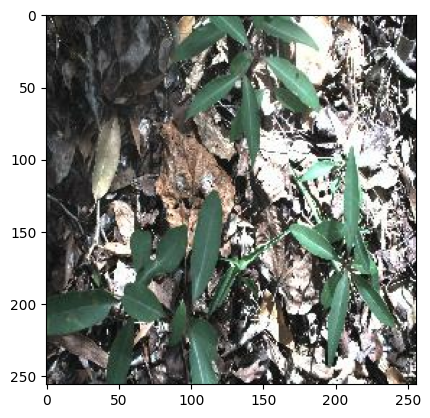

In [19]:
plt.imshow(total_images[9])

In [23]:
for i in idxs:
  if total_images[i] in images_anomaly:
    print(True)

True
True
True
True
True
True
True
True
True
True
True


In [21]:
len(images_anomaly)

11